In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

from global_land_mask import globe

from scipy.stats import boxcox
import random

from sklearn.cluster import KMeans
from sklearn.cross_decomposition import CCA

from sklearn.metrics import mean_squared_error

import clustering_functions as cf
import skill_scores as sc

from eofs.xarray import Eof
from datetime import datetime, timedelta

In [2]:
g0 = 9.80665
extended_winter_months = [11, 12, 1, 2, 3]
winter_months = [12, 1, 2]
years = list(range(1940, 2023))

## Data pre-processing

**Mediterranean**

In [3]:
z500 = cf.preprocess_dataset(filename = '../data.nosync/mediterranean/z500hPa/era5_z500_daily_250_atlantic_1940_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'mediterranean', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = True,
                              rolling_window = 5)

z500 = z500.where(z500['time.year'] > 1980, drop=True)

z500_reshaped = cf.reshape_data_for_clustering(z500)

**Atlantic**

In [3]:
z500 = cf.preprocess_dataset(filename = '../data.nosync/mediterranean/z500hPa/era5_z500_daily_250_atlantic_1940_2022.nc',
                             #filename='../data.nosync/mediterranean/z500hPa/z500_fullatlantic_25_1980_2022.nc',
                              variable_name = 'z', 
                              multiplication_factor = 1/g0, 
                              geographical_filter = 'new atlantic', 
                              months_filter = extended_winter_months, 
                              anomalies = True, 
                              normalization = False,
                              rolling_window = 5)

z500 = z500.where(z500['time.year'] > 1980, drop=True)
z500 = z500.where(z500['time.year'] < 2023, drop=True)


weights = np.cos(np.deg2rad(z500.latitude))
z500 = z500*weights
z500 = z500/z500.std()

z500_reshaped = cf.reshape_data_for_clustering(z500)

In [4]:
pr_regions = xr.open_dataset('results.nosync/CHIRPS_precip_targets/total_pr_admin_areas.nc')['precipitation_amount']
pr_regions = pr_regions.where(pr_regions['time.year'] < 2023, drop=True)

pr_regions_bx = pr_regions.copy()

for i in range(10):
    pr_regions_bx[i, :] = cf.pr_boxcox_transformation(pr_regions_bx[i, :])

## PCA + k-means

In [5]:
pc_number = 15
cluster_number = 5

In [6]:
filepath='results.nosync/model_specifications_and_results/pca_kmeans/v924/s2s/'

In [7]:
eof_solver = Eof(z500, center=True)
pcs_z500 = eof_solver.pcs(npcs=pc_number)
eofs_z500 = eof_solver.eofs()
pca_clusters = KMeans(n_clusters=cluster_number, n_init=50, random_state=0).fit(pcs_z500)

In [8]:
reference_dates_mmdd = [
    '0101', '0108', '0115', '0122', '0201', '0208', '0215', '0222',
    '0301', '0308', '0315', '0322', 
    '0901', '0908', '0915', '0922', '1001', '1008', '1015', '1022',
    '1101', '1108', '1115', '1122', '1201', '1208', '1215', '1222',
]

conditional_probabilities_ls = []
mse_ls = []
cluster_centers = []

for reference_date in reference_dates_mmdd:
    
    print(reference_date)
    
    ds_ensemble = xr.open_dataset("../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_perturbed_members_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')
    ds_single = xr.open_dataset("../data.nosync/S2S_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')

    ds = xr.concat([ds_ensemble, ds_single], dim='number')
    ds_days = ds.groupby(ds['step'].dt.days).mean()

    ds_days_anom = ds_days - ds_days.mean(dim=['time', 'number'])
    #ds_days_anom = ds_days_anom/ds_days_anom.std(dim=['time', 'number'])
    ds_days_anom = ds_days_anom/ds_days_anom.std()
    ds_days_anom = ds_days_anom.rolling(days=5, min_periods=1, center=True).mean()
    ds_days_anom = ds_days_anom.reindex(latitude=list(reversed(ds_days_anom.latitude)))

    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] > -50.5, drop=True)
    ds_days_anom = ds_days_anom*weights
    
    for leadtime in range(47):
        
        probabilities = np.zeros(shape=(41, cluster_number))
        
        for member in range(11):

            selected = ds_days_anom['z'][leadtime, member, :, :, :]

            pseudo_pcs = eof_solver.projectField(selected, neofs=pc_number)
            cluster_labels = pca_clusters.predict(pseudo_pcs)
            
            for i in range(len(cluster_labels)):
                probabilities[i, cluster_labels[i].astype('int')] = probabilities[i, cluster_labels[i].astype('int')]+(1/11)
            
            reconstructed = pseudo_pcs[:, 0]*eofs_z500[0, :, :]
            for i in range(pc_number):
                reconstructed = reconstructed+pseudo_pcs[:, i]*eofs_z500[i, :, :]

            nt,ny,nx = selected.values.shape
            selected_reshaped = np.reshape(selected.values, [nt, ny*nx], order='F')
            reconstructed_reshaped = np.reshape(reconstructed.values, [nt, ny*nx], order='F')
            
            reconstructed_labeled = reconstructed.assign_coords(label=("time", cluster_labels))
            reconstructed_labeled_mean = reconstructed_labeled.groupby('label').mean(dim='time')
            reconstructed_labeled_mean = reconstructed_labeled_mean/weights
            cluster_centers.append(reconstructed_labeled_mean)
            
            mse_reconstruction = mean_squared_error(reconstructed_reshaped, selected_reshaped, multioutput='raw_values')
            mse_ls.append(pd.DataFrame(data={'Method': 'PCA', 'leadtime': leadtime, 'mse': mse_reconstruction}))

        conditional_probabilities_ls.append(pd.DataFrame(data={'Method': 'PCA',
                                                                'forecast_init': selected['time'].dt.date,
                                                               'valid_date': selected['time'].dt.date + timedelta(days=leadtime),
                                                               'leadtime': leadtime,
                                                               str(0): probabilities[:, 0],
                                                               str(1): probabilities[:, 1],
                                                               str(2): probabilities[:, 2],
                                                               str(3): probabilities[:, 3],
                                                               str(4): probabilities[:, 4],
                                                              #str(5): probabilities[:, 5],
                                                              #str(6): probabilities[:, 6],
                                                              #str(7): probabilities[:, 7],
                                                              }))

conditional_probabilities = pd.concat(conditional_probabilities_ls)
mse_total = pd.concat(mse_ls)

conditional_probabilities.to_csv(filepath+'conditional_probabilities_'+str(cluster_number)+'.csv')
mse_total.to_csv(filepath+'mse_'+str(cluster_number)+'.csv')

cluster_centers_concat = xr.concat(cluster_centers, "start_date")
s2s_cluster_centers = cluster_centers_concat.mean(dim='start_date')

0101
0108
0115
0122
0201
0208
0215
0222
0301
0308
0315
0322
0901
0908
0915
0922
1001
1008
1015
1022
1101
1108
1115
1122
1201
1208
1215
1222


In [31]:
def visualise_contourplot_8_s2s(dataset_xarray, unit, regime_names, vmin, vmax, steps, regime_order,
                                color_scheme, col_number=2,borders=True,
                                projection=ccrs.Orthographic(0,45)):
    
    nt,ny,nx = dataset_xarray.values.shape
    x,y = np.meshgrid(dataset_xarray.longitude, dataset_xarray.latitude)

    proj = projection
    fig, axes = plt.subplots(1,col_number, figsize=(14, 5), subplot_kw=dict(projection=proj))

    regimes = regime_names

    for i in regime_order:
        
        count = regime_order[i]
        
        cs = axes.flat[i].contourf(x, y, dataset_xarray[count, :, :],
                                   levels=np.arange(vmin, vmax, steps), 
                                   transform=ccrs.PlateCarree(),
                                   cmap=color_scheme)
        axes.flat[i].coastlines()
        
        if borders==True:
            axes.flat[i].add_feature(cartopy.feature.BORDERS)
            
        title = regimes[i]
        axes.flat[i].set_title(title)
    plt.tight_layout()
    return(fig)

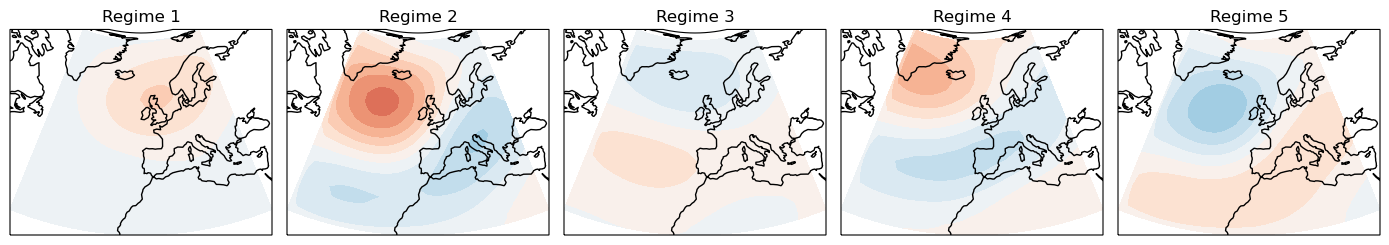

In [29]:
pca_s2s_vis = visualise_contourplot_8_s2s(dataset_xarray = s2s_cluster_centers, 
                                                          unit = '[m]',
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5'],
                                                          vmin=-5, vmax=5.5, steps=0.5, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False, 
                                          regime_order = [2, 1, 0, 3, 4],
                                         projection = ccrs.AlbersEqualArea(central_longitude=-10, central_latitude=50))

plt.savefig('results.nosync/s2s_results/s2s_pca_cluster_centers.png')

In [41]:
s2s_cluster_centers_flat = cf.reshape_data_for_clustering(s2s_cluster_centers)
s2s_cluster_centers_flat_df = pd.DataFrame(s2s_cluster_centers_flat.transpose())
s2s_cluster_centers_flat_df.to_csv('results.nosync/s2s_results/s2s_pca_cluster_centers.csv')

## CCA + kmeans

#### reshape precipitation

In [5]:
z500_reshaped_cca = cf.reshape_data_for_clustering(z500)
pr_reshaped_cca = np.transpose(pr_regions_bx.values, (1, 0))
k=5

In [6]:
filepath_cca='results.nosync/model_specifications_and_results/cca_kmeans/v924/s2s/'

In [7]:
cca = CCA(n_components=10, scale= True, max_iter = 500)

cca.fit(z500_reshaped_cca, pr_reshaped_cca)

z500_cca, pr_cca = cca.transform(z500_reshaped_cca, pr_reshaped_cca)

cca_clusters = KMeans(n_clusters=k, n_init=50, random_state=0).fit(z500_cca)

In [9]:
pr_reshaped_cca.shape

(6352, 10)

In [8]:
reference_dates_mmdd = [
    '0101', '0108', '0115', '0122', '0201', '0208', '0215', '0222',
    '0301', '0308', '0315', '0322', 
    '0901', '0908', '0915', '0922', '1001', '1008', '1015', '1022',
    '1101', '1108', '1115', '1122', '1201', '1208', '1215', '1222',
]

conditional_probabilities_ls = []
mse_ls = []
cluster_centers = []

for reference_date in reference_dates_mmdd:
    
    print(reference_date)
    
    ds_ensemble = xr.open_dataset("../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_perturbed_members_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')
    ds_single = xr.open_dataset("../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')

    ds = xr.concat([ds_ensemble, ds_single], dim='number')
    ds_days = ds.groupby(ds['step'].dt.days).mean()

    ds_days_anom = ds_days - ds_days.mean(dim=['time', 'number'])
    #ds_days_anom = ds_days_anom/ds_days_anom.std(dim=['time', 'number'])
    #ds_days_anom = ds_days_anom/ds_days_anom.std()
    ds_days_anom = ds_days_anom.rolling(days=5, min_periods=1, center=True).mean()
    ds_days_anom = ds_days_anom.reindex(latitude=list(reversed(ds_days_anom.latitude)))

    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] > -50.5, drop=True)
    ds_days_anom = ds_days_anom*weights
    
    for leadtime in range(47):
        
        probabilities = np.zeros(shape=(41, k))
        
        for member in range(11):

            selected = ds_days_anom['z'][leadtime, member, :, :, :]
            selected = selected/selected.std()
            
            nt,ny,nx = selected.values.shape
            selected_reshaped = np.reshape(selected.values, [nt, ny*nx], order='F')

            X_cca, Y_cca = cca.transform(selected_reshaped, pr_reshaped_cca[0:41, :])
            cluster_labels = cca_clusters.predict(X_cca)
            
            for i in range(len(cluster_labels)):
                probabilities[i, cluster_labels[i].astype('int')] = probabilities[i, cluster_labels[i].astype('int')]+(1/11)
            
            reconstructed_space = cca.inverse_transform(X_cca)
            
            reconstructed_space_transformed = reconstructed_space.reshape(nt, ny,nx, order='F')

            reconstructed_space_transformed_xr = xr.DataArray(reconstructed_space_transformed, coords=selected.coords, 
                             dims=selected.dims, attrs=selected.attrs)
                
            reconstructed_labeled = reconstructed_space_transformed_xr.assign_coords(label=("time", cluster_labels))
            reconstructed_labeled_mean = reconstructed_labeled.groupby('label').mean(dim='time')
            reconstructed_labeled_mean = reconstructed_labeled_mean/weights
            cluster_centers.append(reconstructed_labeled_mean)
            
            mse_reconstruction = mean_squared_error(reconstructed_space, selected_reshaped, multioutput='raw_values')
            mse_ls.append(pd.DataFrame(data={'Method': 'CCA', 'leadtime': leadtime, 'mse': mse_reconstruction}))

        conditional_probabilities_ls.append(pd.DataFrame(data={'Method': 'CCA',
                                                                'forecast_init': selected['time'].dt.date,
                                                               'valid_date': selected['time'].dt.date + timedelta(days=leadtime),
                                                               'leadtime': leadtime,
                                                               str(0): probabilities[:, 0],
                                                               str(1): probabilities[:, 1],
                                                               str(2): probabilities[:, 2],
                                                               str(3): probabilities[:, 3],
                                                               str(4): probabilities[:, 4],}))
                                                                                    

conditional_probabilities = pd.concat(conditional_probabilities_ls)
mse_total = pd.concat(mse_ls)

cluster_centers_concat = xr.concat(cluster_centers, "start_date")
s2s_cluster_centers = cluster_centers_concat.mean(dim='start_date')



0101


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800101-20200101.grb.923a8.idx' incompatible with GRIB file


0108


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800108-20200108.grb.923a8.idx' incompatible with GRIB file


0115


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800115-20200115.grb.923a8.idx' incompatible with GRIB file


0122


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800122-20200122.grb.923a8.idx' incompatible with GRIB file


0201


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800201-20200201.grb.923a8.idx' incompatible with GRIB file


0208


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800208-20200208.grb.923a8.idx' incompatible with GRIB file


0215


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800215-20200215.grb.923a8.idx' incompatible with GRIB file


0222


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800222-20200222.grb.923a8.idx' incompatible with GRIB file


0301


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800301-20200301.grb.923a8.idx' incompatible with GRIB file


0308


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800308-20200308.grb.923a8.idx' incompatible with GRIB file


0315


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800315-20200315.grb.923a8.idx' incompatible with GRIB file


0322


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800322-20200322.grb.923a8.idx' incompatible with GRIB file


0901


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800901-20200901.grb.923a8.idx' incompatible with GRIB file


0908


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800908-20200908.grb.923a8.idx' incompatible with GRIB file


0915


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800915-20200915.grb.923a8.idx' incompatible with GRIB file


0922


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19800922-20200922.grb.923a8.idx' incompatible with GRIB file


1001


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801001-20201001.grb.923a8.idx' incompatible with GRIB file


1008


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801008-20201008.grb.923a8.idx' incompatible with GRIB file


1015


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801015-20201015.grb.923a8.idx' incompatible with GRIB file


1022


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801022-20201022.grb.923a8.idx' incompatible with GRIB file


1101


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801101-20201101.grb.923a8.idx' incompatible with GRIB file


1108


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801108-20201108.grb.923a8.idx' incompatible with GRIB file


1115


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801115-20201115.grb.923a8.idx' incompatible with GRIB file


1122


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801122-20201122.grb.923a8.idx' incompatible with GRIB file


1201


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801201-20201201.grb.923a8.idx' incompatible with GRIB file


1208


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801208-20201208.grb.923a8.idx' incompatible with GRIB file


1215


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801215-20201215.grb.923a8.idx' incompatible with GRIB file


1222


Ignoring index file '../data.nosync/s2s_hindcasts_LR_atlantic/plev_data_unperturbed_control_member_19801222-20201222.grb.923a8.idx' incompatible with GRIB file


In [9]:
filepath_cca = 'results.nosync/model_specifications_and_results/cca_kmeans/v924/s2s/'
conditional_probabilities.to_csv(filepath_cca+'conditional_probabilities_'+str(k)+'.csv')
mse_total.to_csv(filepath_cca+'mse.csv')



s2s_cluster_centers_flat = cf.reshape_data_for_clustering(s2s_cluster_centers)
s2s_cluster_centers_flat_df = pd.DataFrame(s2s_cluster_centers_flat.transpose())
s2s_cluster_centers_flat_df.to_csv(filepath_cca+'s2s_cca_cluster_centers.csv')

In [10]:
results = pd.read_csv(filepath_cca+'conditional_probabilities_'+str(k)+'.csv')

In [47]:
centers = pd.read_csv(filepath_cca+'s2s_cca_cluster_centers.csv')[['0', '1', '2', '3', '4']]

In [48]:
centers_ls = []

for i in range(5):
    centers_ls.append(centers[str(i)].values.reshape(ny,nx, order='F'))

centers_reshaped = np.stack(centers_ls)

centers_reshaped_xr = xr.DataArray(centers_reshaped, coords=z500[0:5, :, :].coords, 
                             dims=z500[0:5, :, :].dims, attrs=z500[0:5, :, :].attrs)

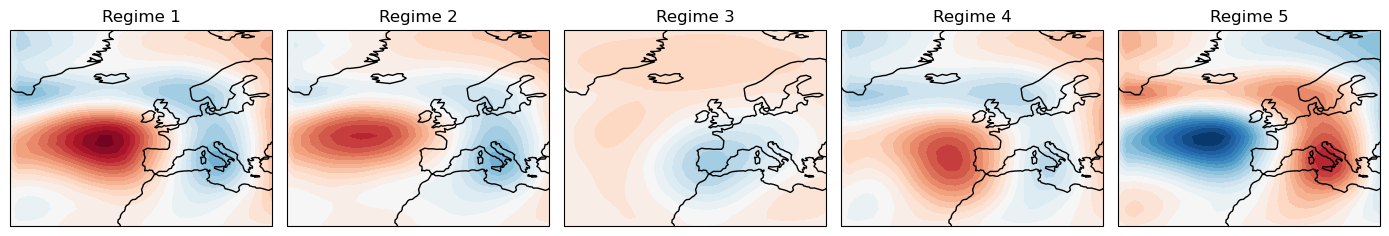

In [52]:
cca_s2s_vis = visualise_contourplot_8_s2s(dataset_xarray = centers_reshaped_xr, 
                                                          unit = '[m]',
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5'],
                                                          vmin=-15, vmax=15, steps=1, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False, 
                                          regime_order = [0, 1, 2, 3, 4],
                                         projection = ccrs.PlateCarree(central_longitude=0))

In [18]:
cca_clusters.labels_[0:10]

array([0, 0, 0, 0, 0, 3, 3, 3, 3, 3], dtype=int32)

In [48]:
k=8

reference_dates_mmdd = [
    '0101', '0108', '0115', '0122', '0201', '0208', '0215', '0222',
    '0301', '0308', '0315', '0322', 
    '0901', '0908', '0915', '0922', '1001', '1008', '1015', '1022',
    '1101', '1108', '1115', '1122', '1201', '1208', '1215', '1222',
]

cluster_centers = []

for reference_date in reference_dates_mmdd:
    
    print(reference_date)
    
    ds_ensemble = xr.open_dataset("../data.nosync/plev_data_perturbed_members_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')
    ds_single = xr.open_dataset("../data.nosync/plev_data_unperturbed_control_member_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')

    ds = xr.concat([ds_ensemble, ds_single], dim='number')
    ds_days = ds.groupby(ds['step'].dt.days).mean()

    ds_days_anom = ds_days - ds_days.mean(dim=['time', 'number'])
    ds_days_anom = ds_days_anom/ds_days_anom.std(dim=['time', 'number'])
    ds_days_anom = ds_days_anom.rolling(days=5, min_periods=1, center=True).mean()
    ds_days_anom = ds_days_anom.reindex(latitude=list(reversed(ds_days_anom.latitude)))

    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] < 45, drop=True)
    
    for leadtime in range(47):
        
        for member in range(11):

            selected = ds_days_anom['z'][leadtime, member, :, :, :]
            
            nt,ny,nx = selected.values.shape
            selected_reshaped = np.reshape(selected.values, [nt, ny*nx], order='F')
            
            X_cca, Y_cca = cca.transform(selected_reshaped, pr_reshaped_cca[0:41, :])
            cluster_labels = cca_clusters.predict(X_cca)
            reconstructed_space = cca.inverse_transform(X_cca)
            
            reconstructed_space_transformed = reconstructed_space.reshape(nt, ny,nx, order='F')

            reconstructed_space_transformed_xr = xr.DataArray(reconstructed_space_transformed, coords=selected.coords, 
                             dims=selected.dims, attrs=selected.attrs)
                
            reconstructed_labeled = reconstructed_space_transformed_xr.assign_coords(label=("time", cluster_labels))
            reconstructed_labeled_mean = reconstructed_labeled.groupby('label').mean(dim='time')
            cluster_centers.append(reconstructed_labeled_mean)

Ignoring index file '../data.nosync/plev_data_perturbed_members_19800101-20200101.grb.923a8.idx' older than GRIB file


0101


Ignoring index file '../data.nosync/plev_data_unperturbed_control_member_19800101-20200101.grb.923a8.idx' older than GRIB file
Ignoring index file '../data.nosync/plev_data_perturbed_members_19800108-20200108.grb.923a8.idx' older than GRIB file


0108
0115
0122
0201
0208
0215
0222
0301
0308
0315
0322
0901
0908
0915
0922
1001
1008
1015
1022
1101
1108
1115
1122
1201
1208
1215
1222


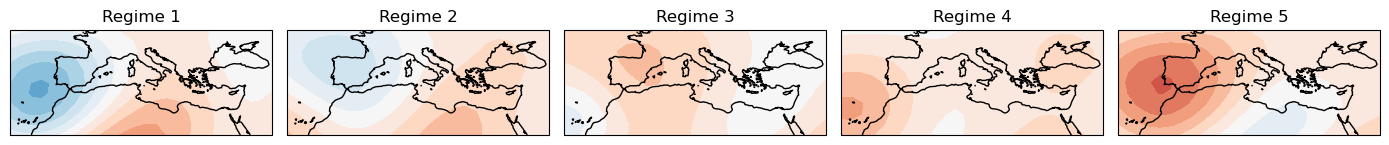

In [49]:
cluster_centers_concat = xr.concat(cluster_centers, "start_date")
s2s_cluster_centers = cluster_centers_concat.mean(dim='start_date')

s2s_cluster_centers_flat = cf.reshape_data_for_clustering(s2s_cluster_centers)
s2s_cluster_centers_flat_df = pd.DataFrame(s2s_cluster_centers_flat.transpose())
s2s_cluster_centers_flat_df.to_csv('results.nosync/s2s_results/s2s_cca_cluster_centers.csv')

cca_s2s_vis = visualise_contourplot_8_s2s(dataset_xarray = s2s_cluster_centers, 
                                                          unit = '[m]',
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5'],
                                                          vmin=-2, vmax=2, steps=0.2, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False, 
                                          regime_order = [1, 2, 3, 4, 0],
                                         projection = ccrs.PlateCarree(central_longitude=0))

plt.savefig('results.nosync/s2s_results/s2s_cca_cluster_centers.png')

### ANNEX

In [ ]:
reference_dates_mmdd = [
    '0101', '0108', '0115', '0122', '0201', '0208', '0215', '0222',
    '0301', '0308', '0315', '0322', 
    '0901', '0908', '0915', '0922', '1001', '1008', '1015', '1022',
    '1101', '1108', '1115', '1122', '1201', '1208', '1215', '1222',
]

#conditional_probabilities_ls = []
cluster_centers = []

for reference_date in reference_dates_mmdd:
    
    print(reference_date)
    
    ds_ensemble = xr.open_dataset("../data.nosync/plev_data_perturbed_members_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')
    ds_single = xr.open_dataset("../data.nosync/plev_data_unperturbed_control_member_1980"+str(reference_date)+"-2020"+str(reference_date)+".grb", engine='cfgrib')

    ds = xr.concat([ds_ensemble, ds_single], dim='number')
    ds_days = ds.groupby(ds['step'].dt.days).mean()

    ds_days_anom = ds_days - ds_days.mean(dim=['time', 'number'])
    ds_days_anom = ds_days_anom/ds_days_anom.std(dim=['time', 'number'])
    ds_days_anom = ds_days_anom.rolling(days=5, min_periods=1, center=True).mean()
    ds_days_anom = ds_days_anom.reindex(latitude=list(reversed(ds_days_anom.latitude)))

    ds_days_anom = ds_days_anom.where(ds_days_anom['longitude'] < 45, drop=True)
    
    for leadtime in range(47):
        
        #probabilities = np.zeros(shape=(41, 5))
        
        for member in range(11):

            selected = ds_days_anom['z'][leadtime, member, :, :, :]

            pseudo_pcs = eof_solver.projectField(selected, neofs=10)
            cluster_labels = pca_clusters.predict(pseudo_pcs)
            
            #for i in range(len(cluster_labels)):
            #    probabilities[i, cluster_labels[i].astype('int')] = probabilities[i, cluster_labels[i].astype('int')]+(1/11)
            
            reconstructed = pseudo_pcs[:, 0]*eofs_z500[0, :, :]
            for i in range(10):
                reconstructed = reconstructed+pseudo_pcs[:, i]*eofs_z500[i, :, :]
                
            reconstructed_labeled = reconstructed.assign_coords(label=("time", cluster_labels))
            reconstructed_labeled_mean = reconstructed_labeled.groupby('label').mean(dim='time')
            cluster_centers.append(reconstructed_labeled_mean)